# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment
Install spp client to your local device: pip install -i https://pip.s2.allenai.org/simple spp_client==0.0.6      

## 1. Get data from annotation store via spp_client

### 1a. Get and set sources
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [1]:
####################################################################
# ANNOTATOR TODO: change this to sha you're analyzing
####################################################################

#This sha will get overwritten when running autogenerater script
sha = 'd85b756b8e4d584a53483c6562eb968efdb1fc0c'


In [2]:
# SPP version for Eval Sample
spp_version = "0.0.81"

# Get annotation sources using annotation store attribute data for given spp_version and sha
import urllib.request, json 

spp_source = f"spp-{spp_version}"
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/pdf/{sha}/annotations?"
                            f"annotationSources=none&attributeSources={spp_source}") as url:
    data = json.load(url)
    
    if not data['attributesFromSource'].get(spp_source):
        print(f"No annotations available for sha {sha} with spp_source {spp_source}")
        print("data:")
        print(json.dumps(data, indent=2))
    else:
        spp_sources_for_version = data['attributesFromSource'][spp_source]
        print(f"Got SPP source info for sha {sha} with spp_source {spp_source}:")
        print(json.dumps(spp_sources_for_version, indent=2))



Got SPP source info for sha d85b756b8e4d584a53483c6562eb968efdb1fc0c with spp_source spp-0.0.81:
{
  "bib-entry": {
    "document-type": [
      "PlainText",
      "PDF"
    ],
    "bib-entry-detector-source": "bib-entry-detector-0.0.1|vila-0.0.2|pdfplumber-0.0.8",
    "bib-entry-predictor-source": "bib_entry_predictor-0.0.1|bib-entry-detector-0.0.1|pdfplumber-0.0.8"
  },
  "plain-text-doc-id": "d7e6b60249dc301db1ffb7588edb719b9d0785f0",
  "dictionary-word-predictor-source": "dwp-0.0.6|vila-0.0.2|pdfplumber-0.0.8",
  "pdf-plumber-source": "pdfplumber-0.0.8",
  "citation": {
    "document-type": [
      "PlainText",
      "PDF"
    ],
    "citation-link-source": "citation-links-0.0.1|bib-entry-detector-0.0.1|citation_mentions-0.0.1",
    "citation-mention-source": "citation_mentions-0.0.1|pdfplumber-0.0.8"
  },
  "layout-parser": "layout-parser-0.0.2|pdfplumber-0.0.8",
  "vila-source": "vila-0.0.2|layout-parser-0.0.2|pdfplumber-0.0.8"
}


### 1b. Retrieve Annotations
Using the sources obtained from the previous cell, we will now retreive the annotations for each source via spp_client.

In [3]:
# Get annotations and data as text using spp client
from spp_client.client import DocumentAnnotations, SppClient

client = SppClient.mk(env="dev")

doc_annos = [
    DocumentAnnotations(
        source = spp_sources_for_version["citation"]["citation-mention-source"],
        annotation_type="citation_mentions"
    ),
    
    DocumentAnnotations(
        source = spp_sources_for_version["bib-entry"]["bib-entry-detector-source"],
        annotation_type="bib_entries"
    ),
    
    DocumentAnnotations(
        source = spp_sources_for_version["bib-entry"]["bib-entry-predictor-source"],
        annotation_type= "bib_entry_titles"
    ),
    
    DocumentAnnotations(
        source = spp_sources_for_version["bib-entry"]["bib-entry-predictor-source"],
        annotation_type= "bib_entry_authors"
    ),  
]

mmda_doc, as_pdf_annos, as_text_annos = client.get_mmda_and_as_docs(
    sha,
    spp_sources_for_version["pdf-plumber-source"],
    doc_annos,
    include_images=True
)

#get doc_id to use for getting linking data
data1 = as_text_annos
doc_id = data1.doc_id

In [4]:
print(mmda_doc.fields)

if 'bib_entries' not in mmda_doc.fields:
    print("No bib_entries!")

['tokens', 'pages', 'rows', 'citation_mentions', 'bib_entries', 'bib_entry_titles', 'bib_entry_authors']


## 2. Visalize Mentions (draw boxes)
Use draw_boxes to visualize each mention.

### 2a. Make boxgroups for mentions so that boxes can be drawn for them.

In [5]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_list = defaultdict(list)
    dictionary_of_boxes = defaultdict(list)
    
    for cite in mmda_doc.citation_mentions:
        for span in cite.spans:
            dictionary_of_boxes[span.box.page].append(span.box) 
    
    #mapping between pages and spans on page
    for page, list_of_boxes in dictionary_of_boxes.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_list[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_list

### 2b. Make boxes for Grobid annotation

In [6]:
import os
import requests
import json
import boto3

####################################################################
# ANNOTATOR TODO: Update with path to your grobid papers and uncomment below
# if the s3 code doesn't work.
# Annos are in s3://ai2-s2-mmda/citation-link-evaluation-sample-2/grobid_annotation
####################################################################
# with open(f'/Users/baileyk/Work/mmda/spp_grobid/{sha}.json') as f:
#     grobid_annotation = json.load(f)

# s3 code
s3_resource = boto3.resource('s3')
key = f"citation-link-evaluation-sample-2/grobid_annotation/{sha}.json"
obj = s3_resource.Object("ai2-s2-mmda", key)

try:
    grobid_annotation = json.loads(obj.get()["Body"].read().decode("utf-8"))
    print("grobid annos found.")
except:
    print(f"no grobid annotations found at s3://ai2-s2-mmda/{key}")
    grobid_annotation = dict()

grobid annos found.


In [7]:
def make_boxgroup_mentions_from_grobid(grobid_annotation):
    result_boxes_list = defaultdict(list)
    for mention in grobid_annotation["refMarkers"]:
        page = mention["p"]
        box = lpe.Rectangle(
            mention["x"], 
            mention["y"], 
            mention["x"] + mention["w"],
            mention["y"] + mention["h"]
        )
        result_boxes_list[page].append(box)
    return result_boxes_list

#egor version
def draw_boxgroups(image, rectangle_list, color_map=None, id_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle,
                                 type=f'color_1'
                                )
                  )

    if image:
        return lpv.draw_box(image,
                            viz,
                            color_map=color_map,
                            show_element_id=False,
                            id_font_size=12,
                            id_text_color='blue'
                            )
    
    return None

In [8]:
# annotate the doc with grobid mentions and bibs
from mmda.types.annotation import BoxGroup, Box, Metadata

# make grobid mention box groups:
grobid_mention_box_groups = []
for anno in grobid_annotation['refMarkers']:
    metadata = Metadata()
    metadata['bib_entry_id'] = anno.get('id')

    grobid_mention_box_groups.append(BoxGroup(
        boxes=[Box(l=anno['x'], t=anno['y'], w=anno['w'], h=anno['h'], 
        # grobid is silly
        page=anno['p']-1
        ).get_relative(
            page_width=grobid_annotation['pages'][anno['p']-1]['page_width'],
            page_height=grobid_annotation['pages'][anno['p']-1]['page_height'],
        )],
        metadata=metadata
        )
    )
print(f"{len(grobid_mention_box_groups)} grobid mentions.")
    

# make grobid bib entry box groups:
grobid_bib_entry_box_groups = []
for anno in grobid_annotation['refBibs']:
    bib_boxes = []
    for box in anno['pos']:
        bib_boxes.append(Box(l=box['x'], t=box['y'], w=box['w'], h=box['h'], 
        # grobid is silly
        page=box['p']-1).get_relative(
            page_width=grobid_annotation['pages'][box['p']-1]['page_width'],
            page_height=grobid_annotation['pages'][box['p']-1]['page_height'],
            )
        )

    grobid_bib_entry_box_groups.append(BoxGroup(
        boxes=bib_boxes,
        id=anno['id']
        )
    )
print(f"{len(grobid_bib_entry_box_groups)} grobid bibs.")


mmda_doc.annotate(grobid_mentions=grobid_mention_box_groups)
mmda_doc.annotate(grobid_bibs=grobid_bib_entry_box_groups)

mmda_doc.fields

92 grobid mentions.
28 grobid bibs.


['tokens',
 'pages',
 'rows',
 'citation_mentions',
 'bib_entries',
 'bib_entry_titles',
 'bib_entry_authors',
 'grobid_mentions',
 'grobid_bibs']

## 3. Get references and s2 id's for each mention.

### 3a. Retreive citation mention numbers and which bib entries they are linked to.

In [9]:
# get annotation data from json file, plain-text
import urllib.request, json 
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/plain-text/{doc_id}/annotations?"
                            f"annotationSources=all&attributeSources=all") as url:
    data = json.load(url)

mention_detection_source = spp_sources_for_version["citation"]["citation-mention-source"]
bib_mention_linker_source = spp_sources_for_version["citation"]["citation-link-source"]

# ie: for citation_mention '0', the bib_entry_id it's linked to is '3'. 
citation_links = defaultdict(int)

for i in data['annotationsFromSource'][f'{mention_detection_source}']['citation_mentions']:
    #set key to citation mention
    citation_mention_id = i['attributesFromSource'][mention_detection_source]['id']
    
    #set value to bib entry id
    linked_bib_id = i['attributesFromSource'][bib_mention_linker_source]['bib_entry_id']
    
    #add to list of citation link data
    citation_links[citation_mention_id] = int(linked_bib_id)

### 3b. Use API call to find what s2 paper each bib entry is linked to.

In [10]:
def get_index_of_bib_entry_with_id(bib_entry_id):
    linked_bib_entry_index_list = [i for i, bib_entry in enumerate(mmda_doc.bib_entries) if bib_entry.id == bib_entry_id]
    assert len(linked_bib_entry_index_list) == 1, f"there should be exactly one bib_entry with the id {bib_entry_id}."
    return linked_bib_entry_index_list[0]

def extract_first_group_symbols(span_groups):
    if len(span_groups) > 1:
        print("warning: multiple span_groups detected when 0 or 1 expected")
    try: 
        first_one = span_groups[0] 
        text = first_one.symbols[0]
    except IndexError: # case where was no annotation detected so span_groups was empty list
            text = "" # it can be empty or say "no text detected" or something
    return text


def get_bib_entry_title(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    # print("linked_bib_id: ", linked_bib_id)
    # Accessing the linked bib_entry this way is error-prone because MMDA annotations can't be assumed to be sorted by SpanGroup IDs
    # bib_title_span_groups = mmda_doc.bib_entries[linked_bib_id].bib_entry_titles 
    # We have to find the correct bib_entry this way:
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)
    
    bib_title_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_titles 
    text_symbols = extract_first_group_symbols(bib_title_span_groups)

    return text_symbols

def get_full_bib_entry_text(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)

    bib_span_groups = [mmda_doc.bib_entries[linked_bib_index]]
    text_symbols = extract_first_group_symbols(bib_span_groups)

    return text_symbols

In [11]:
#make api call to get linked papers
def bibLinkingApiPost(title, end_point='http://pipeline-api.prod.s2.allenai.org/citation/match'):
    payload = json.dumps([{'title': title}])
    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", end_point, headers=headers, data=payload).json()
    return response


#get s2_ids linked to each mention
s2_ids = []
for citation_mention in mmda_doc.citation_mentions:
    title = get_bib_entry_title(citation_mention.id)
    s2_ids.append(str((bibLinkingApiPost(title))).replace('[', '').replace(']', ''))

print(s2_ids)

['235446522', '235446522', '206591190', '6070091', '54558282', '211506988', '174801560', '18021059', '1843173', '9579103', '54475483', '53875671', '2429016', '19052864', '-1', '214713500', '3865699', '3477836', '11003934', '214713500', '214713500', '20282961', '20282961', '235446522', '208139191', '235446522', '235446522', '20635214', '20635214', '235446522', '-1', '214713500', '3865699', '20282961', '214713500', '20282961', '20282961', '214713500', '20282961', '20282961', '214713500', '235446522', '10328909', '-1', '235446522', '206591190', '6070091', '235446522', '206591190', '20635214', '6070091', '235446522', '235446522', '10328909', '14113767', '-1', '218470050', '235446522', '561197', '206591190', '6070091', '2429016', '19052864', '3865699', '214713500', '20635214', '235446522', '20635214', '235446522', '235446522', '235446522', '235446522', '-1', '221319569', '235446522', '235446522', '235446522', '235446522', '-1', '6070091', '206591190', '3865699']


## 4. Annotation Info!

In [12]:
####################################################################
# ANNOTATOR TODO: Record page # from output in annotation spreadsheet
####################################################################

# get random page number to review and annotate
import random

pages_w_mentions = [citation_mention.pages[0].id + 1 for citation_mention in mmda_doc.citation_mentions for citation_mention in mmda_doc.citation_mentions]

annot_page = random.choice(pages_w_mentions)
print("page to annotate:", annot_page)

page to annotate: 7


In [13]:
# gives table of SPP mentions and their corresponding bib_entry ids 
# (if the doc is annotated with bib_entries), and s2 linked papers 
import pandas as pd
from IPython.display import HTML

if 'bib_entries' in mmda_doc.fields:
    ref_info = {
        # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
        "Page": [citation_mention.pages[0].id + 1 for citation_mention in mmda_doc.citation_mentions],
        "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
        "Linked Bib id": [citation_links[citation_mention.id] for citation_mention in mmda_doc.citation_mentions],
        # TODO: use DWP "words" text instead of doc.symbols (ex: the title "Reaction-Diﬀusion processes and meta-population mod-\nels in Heterogeneous Networks" gives no match, but manually changing "mod-\nels" to "models" results in an S2 id match)
        "Linked Bib Entry Title": [get_bib_entry_title(citation_mention.id) for citation_mention in mmda_doc.citation_mentions],    
        "Linked Bib Entry Extracted Text": [get_full_bib_entry_text(citation_mention.id) for citation_mention in mmda_doc.citation_mentions],    
        "S2 id:": [ids if ids != str(-1) else " " for ids in s2_ids],
        "S2 url": [f"http://api.semanticscholar.org/corpusid:{ids}" if ids != str(-1) else " " for ids in s2_ids]
        }
else:
    ref_info = {
    # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
    "Page": [citation_mention.pages[0].id + 1 for citation_mention in mmda_doc.citation_mentions],
    "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
    # TODO: use DWP "words" text instead of doc.symbols (ex: the title "Reaction-Diﬀusion processes and meta-population mod-\nels in Heterogeneous Networks" gives no match, but manually changing "mod-\nels" to "models" results in an S2 id match)
    "Linked Bib Entry Title": ["no bibs" for citation_mention in mmda_doc.citation_mentions],    
    "Linked Bib Entry Extracted Text": ["no bibs" for citation_mention in mmda_doc.citation_mentions],    
    "S2 id:": ["no bibs" for ids in s2_ids],
    "S2 url": ["no bibs" for ids in s2_ids]
    }

spp_df = pd.DataFrame.from_dict(ref_info, orient='index')
spp_df = spp_df.transpose()

# selecting rows based on random page selected to annotate
# you can comment the line below out to see all mentions across all pages
spp_df = spp_df[spp_df['Page'] == annot_page]


# make s2 links clickable
print("SPP:")
HTML(spp_df.to_html(render_links=True, escape=False))

SPP:


,Page,Mention text,Linked Bib id,Linked Bib Entry Title,Linked Bib Entry Extracted Text,S2 id:,S2 url
58,7,[9],8,"Observe locally, infer globally: A\nspace-time mrf for detecting abnormal activities with incre-\nmental updates","[9] J. Kim and K. Grauman. Observe locally, infer globally: A\nspace-time mrf for detecting abnormal activities with incre-\nmental updates. In CVPR , 2009.",561197,http://api.semanticscholar.org/corpusid:561197
59,7,[16],15,Anomaly detection in crowded scenes,"[16] V. Mahadevan, W. Li, V. Bhalodia, and N. Vasconcelos.\nAnomaly detection in crowded scenes. In CVPR , 2010.",206591190,http://api.semanticscholar.org/corpusid:206591190
60,7,[14],13,Abnormal event detection at 150 fps\nin matlab,"[14] C. Lu, J. Shi, and J. Jia. Abnormal event detection at 150 fps\nin matlab. In ICCV , 2013.",6070091,http://api.semanticscholar.org/corpusid:6070091
61,7,[3],2,Learning temporal regularity in video se-\nquences,"3] M. Hasan, J. Choi, J. Neumann, A. K. Roy-Chowdhury,\nand L. S. Davis. Learning temporal regularity in video se-\nquences. In CVPR , 2016.",2429016,http://api.semanticscholar.org/corpusid:2429016
62,7,[15],14,A revisit of sparse coding based\nanomaly detection in stacked rnn framework,"[15] W. Luo, W. Liu, and S. Gao. A revisit of sparse coding based\nanomaly detection in stacked rnn framework. In ICCV , 2017.",19052864,http://api.semanticscholar.org/corpusid:19052864
63,7,[13],12,Future frame prediction\nfor anomaly detection - a new baseline,"[13] W. Liu, W. Luo, D. Lian, and S. Gao. Future frame prediction\nfor anomaly detection - a new baseline. In CVPR , 2018.",3865699,http://api.semanticscholar.org/corpusid:3865699
64,7,[18],17,Learning memory-guided nor-\nmality for anomaly detection,"[18] H. Park, J. Noh, and B. Ham. Learning memory-guided nor-\nmality for anomaly detection. In CVPR , 2020.",214713500,http://api.semanticscholar.org/corpusid:214713500
65,7,[5],4,Joint detection and recount-\ning of abnormal events by learning deep generic knowledge,"[5] R. Hinami, T. Mei, and S. Satoh. Joint detection and recount-\ning of abnormal events by learning deep generic knowledge.\nIn ICCV , 2017.",20635214,http://api.semanticscholar.org/corpusid:20635214
66,7,[25],24,X-MAN: Ex-\nplaining multiple sources of anomalies in video,"[25] S. Szymanowicz, J. Charles, and R. Cipolla. X-MAN: Ex-\nplaining multiple sources of anomalies in video. In CVPR\nWorkshops , 2021.",235446522,http://api.semanticscholar.org/corpusid:235446522
67,7,[5],4,Joint detection and recount-\ning of abnormal events by learning deep generic knowledge,"[5] R. Hinami, T. Mei, and S. Satoh. Joint detection and recount-\ning of abnormal events by learning deep generic knowledge.\nIn ICCV , 2017.",20635214,http://api.semanticscholar.org/corpusid:20635214


In [14]:
# gives table of GROBID mentions and their corresponding bib_entry ids, s2 linked papers 
import pandas as pd
from IPython.display import HTML

def get_index_of_grobid_bib_entry_with_id(grobid_bib_entry_id):
    linked_bib_entry_index_list = [i for i, grobid_bib_entry in enumerate(mmda_doc.grobid_bibs) if grobid_bib_entry.box_group.id == grobid_bib_entry_id]
    assert len(linked_bib_entry_index_list) <2, f"there should be no more than one grobid bib entry with the id {grobid_bib_entry_id}. \ninstead, we got this: {linked_bib_entry_index_list}"
    return linked_bib_entry_index_list[0] if len(linked_bib_entry_index_list) == 1 else None


def get_full_grobid_bib_entry_text(grobid_mention):
    linked_grobid_bib_id = grobid_mention.box_group.metadata.bib_entry_id
    linked_grobid_bib_index = get_index_of_grobid_bib_entry_with_id(linked_grobid_bib_id)
    if linked_grobid_bib_index == None:
        return None
    else:
        grobid_bib_span_groups = [mmda_doc.grobid_bibs[linked_grobid_bib_index]]
        text_symbols = extract_first_group_symbols(grobid_bib_span_groups)
    return text_symbols

# get titles from bibentry-predictor API
def get_linked_bib_title_from_bib_predictor(grobid_mention):
    bib_text = get_full_grobid_bib_entry_text(grobid_mention)
    if bib_text:
        payload = json.dumps({"instances": [{"bib_entry": bib_text}]})    
        headers = {
            'Content-Type': 'application/json'
        }
        end_point = "http://bibentry-predictor.v0.dev.models.s2.allenai.org/invocations"

        response = requests.request("POST", end_point, headers=headers, data=payload).json()
        title_prediction = response['predictions'][0].get('title', 'no title detected')
    else:
        return None
    return title_prediction


linked_bib_entry_titles_grobid = [get_linked_bib_title_from_bib_predictor(grobid_mention) for grobid_mention in mmda_doc.grobid_mentions]


#get grobid_s2_ids linked to each mention
grobid_s2_ids = []
for title in linked_bib_entry_titles_grobid:
    if title:
        grobid_s2_ids.append(str((bibLinkingApiPost(title))).replace('[', '').replace(']', ''))
    else:
        grobid_s2_ids.append(None)

print(grobid_s2_ids)

ref_info = {
    "Page": [grobid_mention.pages[0].id for grobid_mention in mmda_doc.grobid_mentions], # i removed +1 becuz grobid??
    "Mention text": [grobid_mention.symbols for grobid_mention in mmda_doc.grobid_mentions],
    "Linked Bib Entry ID": [grobid_mention.box_group.metadata.bib_entry_id for grobid_mention in mmda_doc.grobid_mentions],    
    "Linked Bib Entry Title": linked_bib_entry_titles_grobid,
    "Linked Bib Entry Extracted Text": [get_full_grobid_bib_entry_text(grobid_mention) for grobid_mention in mmda_doc.grobid_mentions],
    "S2 id:": [id if id != str(-1) else " " for id in grobid_s2_ids],
    "S2 url": [f"http://api.semanticscholar.org/corpusid:{id}" if id not in [str(-1), None] else " " for id in grobid_s2_ids]

     }
    
grobid_df = pd.DataFrame.from_dict(ref_info, orient='index')
grobid_df = grobid_df.transpose()

# selecting rows based on random page selected to annotate
# you can comment the line below out to see all mentions across all pages
# grobid_df = grobid_df[grobid_df['Page'] == annot_page - 1]


#make s2 links clickable
print("Grobid:")
HTML(grobid_df.to_html(render_links=True, escape=False))

['235446522', '54463801', '235446522', '206591190', '6070091', '54558282', '211506988', '174801560', '18021059', '1843173', '-1', '54475483', '53875671', '2429016', '19052864', '52189274', '214713500', '3865699', '3477836', '11003934', '214713500', '214713500', '20282961', '20282961', '235446522', '208139191', '235446522', '235446522', '20635214', '20635214', '235446522', '3719281', '214713500', '3865699', '20282961', '214713500', '20282961', '20282961', '214713500', '20282961', '20282961', '214713500', '235446522', '10328909', '54463801', '235446522', '206591190', '6070091', '235446522', '206591190', '20635214', '6070091', '235446522', '18021059', None, '2429016', None, '54463801', None, '10328909', None, '6070091', None, '235446522', '10328909', '14113767', '54463801', '218470050', '561197', '206591190', '6070091', '2429016', '19052864', '3865699', '214713500', '20635214', '235446522', '20635214', '235446522', '235446522', '235446522', '235446522', '54463801', '221319569', '235446522

,Page,Mention text,Linked Bib Entry ID,Linked Bib Entry Title,Linked Bib Entry Extracted Text,S2 id:,S2 url
0,0,[[25]],b24,X-MAN: Explaining multiple sources of anomalies in video,"S. Szymanowicz, J. Charles, and R. Cipolla. X-MAN: Ex-\nplaining multiple sources of anomalies in video. In CVPR\nWorkshops , 2021.",235446522,http://api.semanticscholar.org/corpusid:235446522
1,0,[(1)],b0,Slowfast networks for video recognition,"C. Feichtenhofer, H. Fan, J. Malik, and K. He. Slowfast net-\nworks for video recognition. In ICCV , 2019.",54463801,http://api.semanticscholar.org/corpusid:54463801
2,1,[[25]],b24,X-MAN: Explaining multiple sources of anomalies in video,"S. Szymanowicz, J. Charles, and R. Cipolla. X-MAN: Ex-\nplaining multiple sources of anomalies in video. In CVPR\nWorkshops , 2021.",235446522,http://api.semanticscholar.org/corpusid:235446522
3,1,[[16]],b15,Anomaly detection in crowded scenes,"V. Mahadevan, W. Li, V. Bhalodia, and N. Vasconcelos.\nAnomaly detection in crowded scenes. In CVPR , 2010.",206591190,http://api.semanticscholar.org/corpusid:206591190
4,1,[[14]],b13,Abnormal event detection at 150 fps\nin matlab,"C. Lu, J. Shi, and J. Jia. Abnormal event detection at 150 fps\nin matlab. In ICCV , 2013.",6070091,http://api.semanticscholar.org/corpusid:6070091
5,1,"[[4,]",b3,Deep\nanomaly detection with outlier exposure,"D. Hendrycks, M. Mazeika, and T. Dietterich.\nDeep\nanomaly detection with outlier exposure. arXiv preprint\narXiv:1812.04606 , 2018.",54558282,http://api.semanticscholar.org/corpusid:54558282
6,1,"[6,]",b5,Generalized odin: Detecting out-of-distribution image without learning from out-of-distribution data,"Yen-Chang Hsu, Yilin Shen, Hongxia Jin, and Zsolt Kira.\nGeneralized odin: Detecting out-of-distribution image with-\nout learning from out-of-distribution data. In CVPR , 2020.",211506988,http://api.semanticscholar.org/corpusid:211506988
7,1,[21]],b20,Likelihood ratios for out-of-distribution detection,"Jie Ren, Peter J Liu, Emily Fertig, Jasper Snoek, Ryan\nPoplin, Mark A DePristo, Joshua V Dillon, and Balaji Lak-\nshminarayanan. Likelihood ratios for out-of-distribution de-\ntection. arXiv preprint arXiv:1906.02845 , 2019.",174801560,http://api.semanticscholar.org/corpusid:174801560
8,1,"[[17,]",b16,Analyzing tracklets for the detection of abnormal\ncrowd behavior,"H. Mousavi, S. Mohammadi, A. Perina, R. Chellali, and V.\nMurino. Analyzing tracklets for the detection of abnormal\ncrowd behavior. In WACV , 2015.",18021059,http://api.semanticscholar.org/corpusid:18021059
9,1,"[24,]",b23,Realtime anomaly detection and localization in crowded scenes,"M. Sabokrou, M. Fathy, M. Hoseini, and R. Klette. Real-\ntime anomaly detection and localization in crowded scenes.\nIn CVPR , 2015.",1843173,http://api.semanticscholar.org/corpusid:1843173


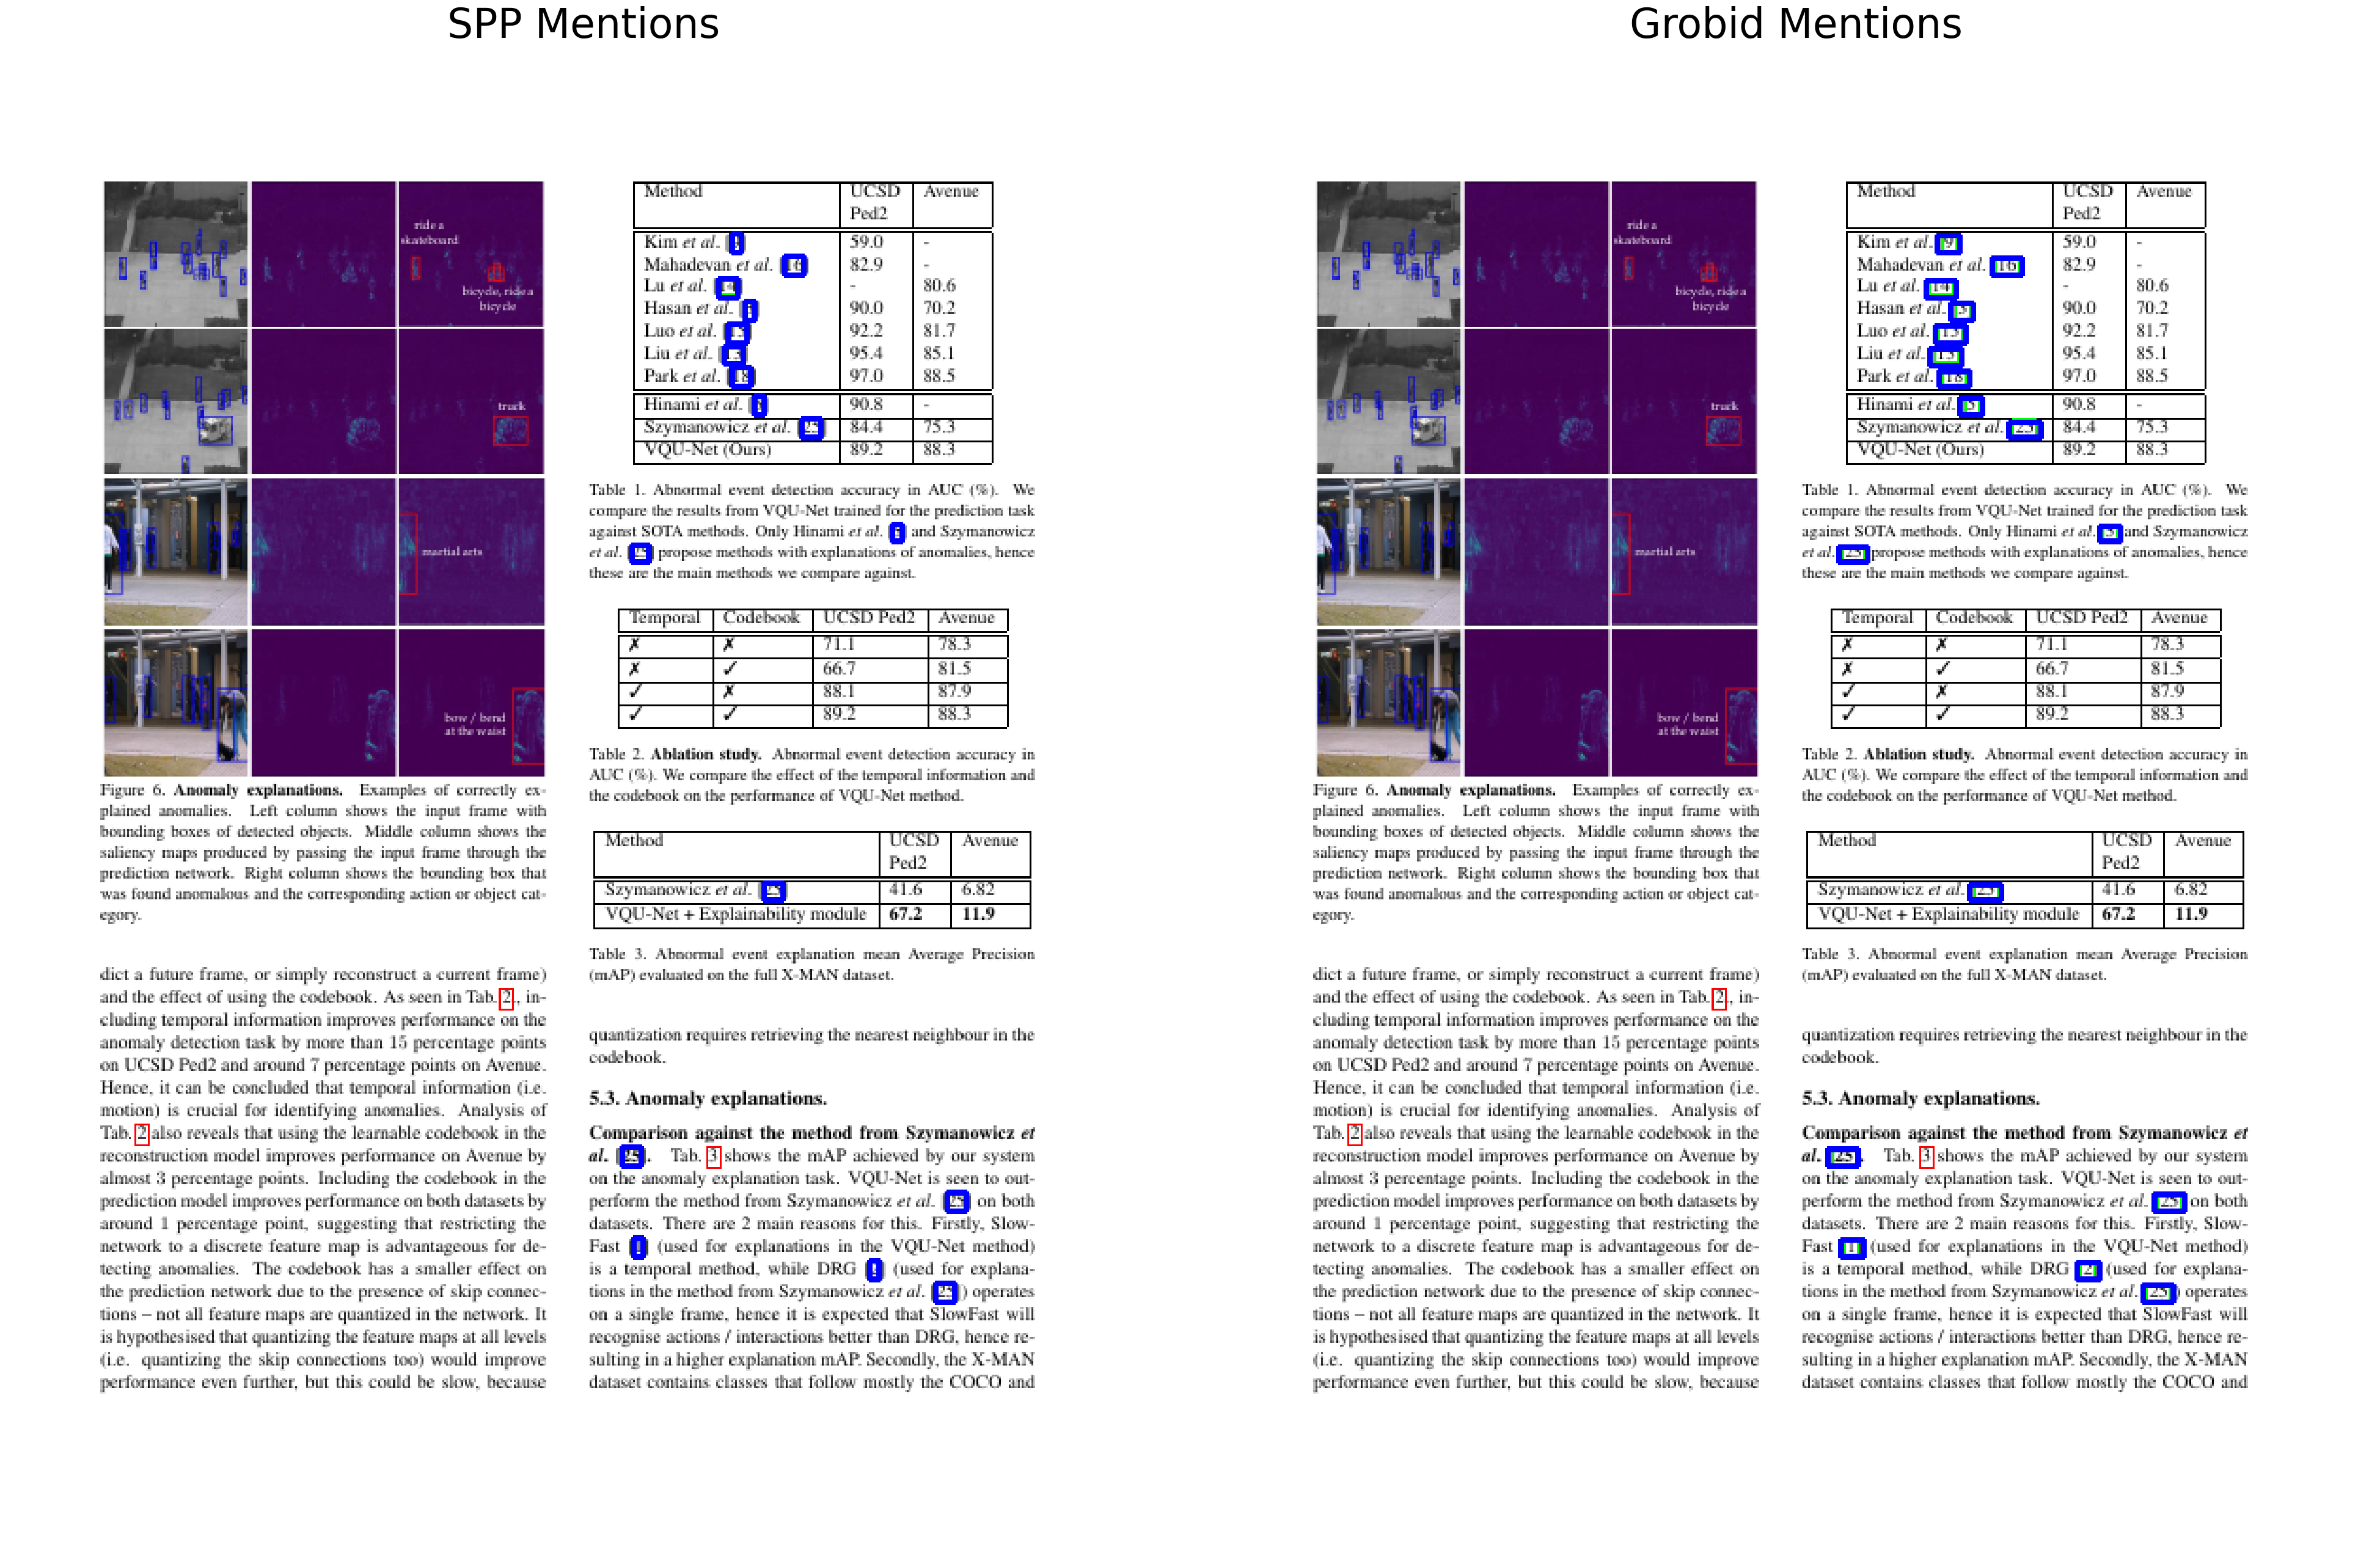

In [15]:
# mentions imgs
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


rows = 1
columns = 2
fontsize = 48

#spp
#make boxes and save as image
dic_boxgroups = make_boxgroups_mentions(mmda_doc)
image1 = draw_boxgroups(mmda_doc.images[annot_page-1], list(dic_boxgroups[annot_page-1]))

#plot
fig = plt.figure(figsize=(50, 50))
fig.add_subplot(rows, columns, 1)
plt.axis('off')
plt.title("SPP Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image1)


#grobid
#make boxes and save as image
boxgroups = make_boxgroup_mentions_from_grobid(grobid_annotation)
image2 = draw_boxgroups(mmda_doc.images[annot_page-1], list(boxgroups[annot_page]))

#plot side by side
fig.add_subplot(rows, columns, 2)
plt.axis('off')
plt.title("Grobid Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image2)
plt.subplots_adjust(bottom=0.15, wspace=0.05)

In [16]:
mmda_doc.grobid_bibs[0]

SpanGroup(uuid='11db9f8d-4e86-47a5-bd51-7ddf6dfd0972', doc=<mmda.types.document.Document object at 0x12fc62070>, metadata=Metadata({'id': 0, 'type': None, 'text': None}), spans=[Span(start=30844, end=30949, box=Box(l=0.5372238562091504, t=0.4490067454545459, w=0.35347631895424836, h=0.025158333333333394, page=7))], box_group=BoxGroup(uuid='5763e17b-7425-496a-9cf7-96bf1bf6cd2d', doc=None, metadata=Metadata({'id': 'b0', 'type': None}), boxes=[Box(l=0.5372303921568627, t=0.4505113636363636, w=0.3534686274509802, h=0.009815530303030336, page=7), Box(l=0.5372238562091504, t=0.46414520202020204, w=0.2614892156862744, h=0.010018813131313167, page=7)], id='b0', type=None), id=0, type=None, text='C. Feichtenhofer, H. Fan, J. Malik, and K. He. Slowfast net-\nworks for video recognition. In ICCV , 2019.')

In [17]:
def draw_text_blocks(page, text_blocks_dictionary, color_map=None, id_map=None):
    image = mmda_doc.images[page]

    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    if image:
        return lpv.draw_box(image,
                            text_blocks_dictionary[page],
                            color_map=color_map,
                            show_element_id=True,
                            id_font_size=10
                            # id_text_background_alpha=0.2
                            )
    
    return None

#function to create labeled text blocks from grobid bibs on the mmda doc
def make_text_blocks_bibs(mmda_doc):

    result_text_blocks_list = defaultdict(list)
    dictionary_of_box_groups = defaultdict(list)
    
    for bib in mmda_doc.bib_entries:
        # it's always 1 box
        dictionary_of_box_groups[bib.box_group.boxes[0].page].append(bib.box_group)
    
    #mapping between pages and spans on page
    for page, box_groups in dictionary_of_box_groups.items():
        page_w, page_h = mmda_doc.images[page].size

        for box_group in box_groups:
            # it's always 1 box
            box = box_group.boxes[0]
            rect = lpe.Rectangle(
                    box.l * page_w,
                    box.t * page_h,
                    (box.l + box.w) * page_w,
                    (box.t + box.h) * page_h
                )
            result_text_blocks_list[page].append(lpe.TextBlock(
                rect,
                id=box_group.id,
                type='color_1'
            ))
    return result_text_blocks_list

### SPP Bibs Pages

page 7:


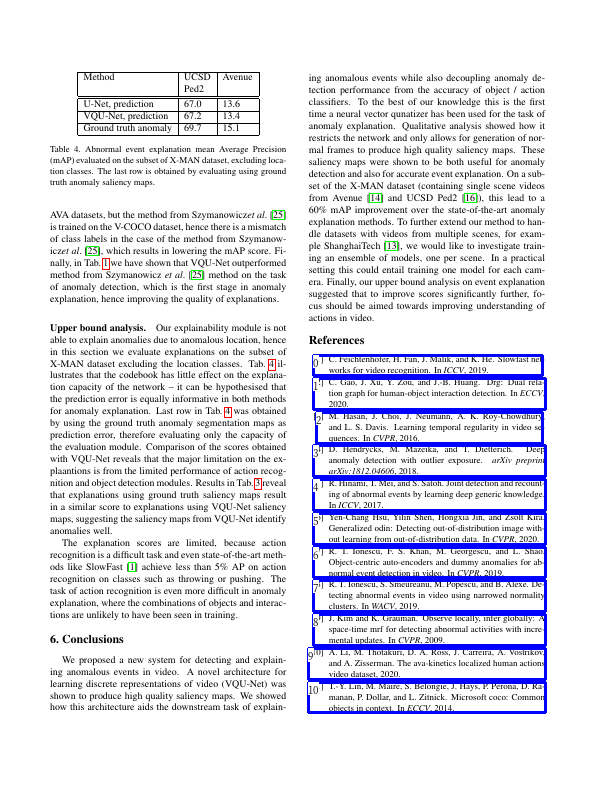

page 8:


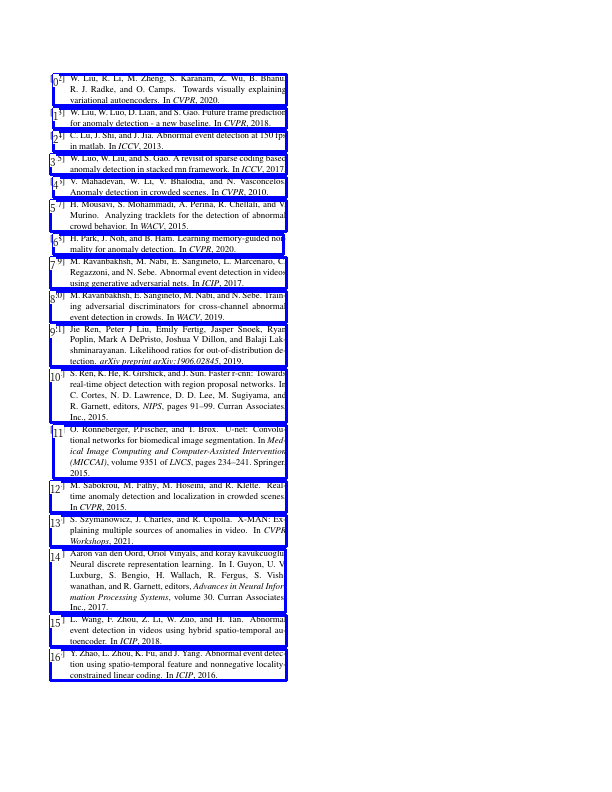

In [18]:
# bibs imgs
bib_pages = set([bib_entry.box_group.boxes[0].page for bib_entry in mmda_doc.bib_entries])

rows = len(bib_pages)
columns = 2
fontsize = 48

#spp
#make bib text blocks and save as image
dic_text_blocks = make_text_blocks_bibs(mmda_doc)
bib_pages = sorted(list(bib_pages))
for page in bib_pages:
    print(f"page {page}:")
    display(draw_text_blocks(page, dic_text_blocks))


### Grobid Bibs Pages

In [19]:
mmda_doc.grobid_bibs[0]

SpanGroup(uuid='11db9f8d-4e86-47a5-bd51-7ddf6dfd0972', doc=<mmda.types.document.Document object at 0x12fc62070>, metadata=Metadata({'id': 0, 'type': None, 'text': None}), spans=[Span(start=30844, end=30949, box=Box(l=0.5372238562091504, t=0.4490067454545459, w=0.35347631895424836, h=0.025158333333333394, page=7))], box_group=BoxGroup(uuid='5763e17b-7425-496a-9cf7-96bf1bf6cd2d', doc=None, metadata=Metadata({'id': 'b0', 'type': None}), boxes=[Box(l=0.5372303921568627, t=0.4505113636363636, w=0.3534686274509802, h=0.009815530303030336, page=7), Box(l=0.5372238562091504, t=0.46414520202020204, w=0.2614892156862744, h=0.010018813131313167, page=7)], id='b0', type=None), id=0, type=None, text='C. Feichtenhofer, H. Fan, J. Malik, and K. He. Slowfast net-\nworks for video recognition. In ICCV , 2019.')

bib_pages {8, 7}
page 7:


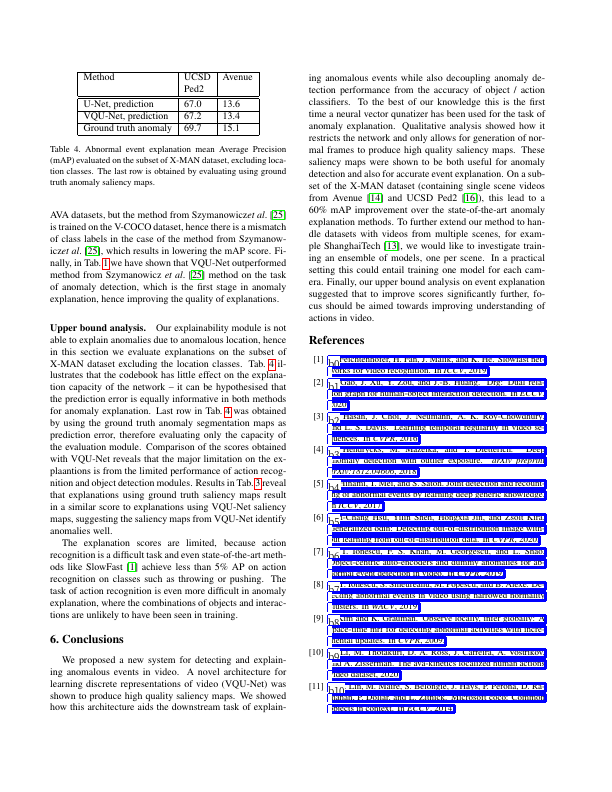

page 8:


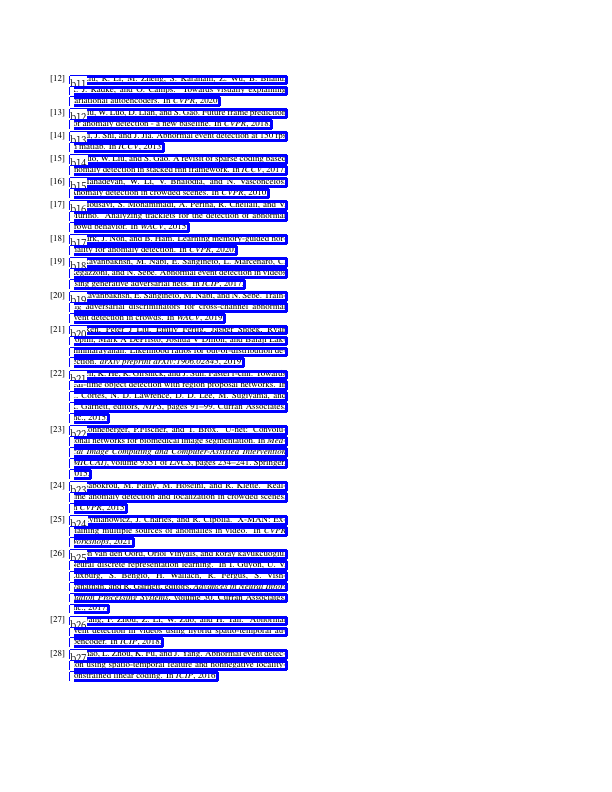

In [20]:
#function to create labeled text blocks from bibs on the mmda doc
def make_text_blocks_grobid_bibs(mmda_doc):

    result_text_blocks_list = defaultdict(list)
    dictionary_of_box_groups = defaultdict(list)
    
    for bib in mmda_doc.grobid_bibs:
        dictionary_of_box_groups[bib.box_group.boxes[0].page].append(bib.box_group)
    
    #mapping between pages and spans on page
    for page, box_groups in dictionary_of_box_groups.items():
        page_w, page_h = mmda_doc.images[page].size

        for box_group in box_groups:
            # it's usually multiple boxes
            for i, box in enumerate(box_group.boxes):
                box_id = box_group.id if i == 0 else " "
                rect = lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    )
                result_text_blocks_list[page].append(lpe.TextBlock(
                    rect,
                    id=box_id,
                    type='color_1'
                ))
    return result_text_blocks_list
    
# bibs imgs
bib_pages = set([bib_entry.box_group.boxes[0].page for bib_entry in mmda_doc.grobid_bibs])
print('bib_pages', bib_pages)
rows = len(bib_pages)
columns = 2
fontsize = 48

#grobid
#make bib text blocks and save as image
dic_text_blocks = make_text_blocks_grobid_bibs(mmda_doc)
bib_pages = sorted(list(bib_pages))
for page in bib_pages:
    print(f"page {page}:")
    display(draw_text_blocks(page, dic_text_blocks))


## ANNOTATOR TODO: 
Record each mention on this page (regardless of if it got recognized by SPP or not) as 1 row in the spreadsheet.